In [26]:
# Pull the data
query = "SELECT * FROM DS_TEST_DB.DKEARNY.CJ_L_MAIN_STATIC_AGGREGATED"
df = sf.pull_sql_to_df(query)

In [27]:
# Data filtering
df = df[df['CORONA_TOTAL'] > 0]
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])
df = df.sort_values(by=['USER_ID', 'TRANSACTION_DATE'])

# Calculate the purchase counts
user_purchase_counts = df.groupby('USER_ID')['TRANSACTION_DATE'].nunique().reset_index()
user_purchase_counts.columns = ['USER_ID', 'PURCHASE_COUNT']

# Merge the purchase counts with the original data
data_with_purchase_counts = pd.merge(df, user_purchase_counts, on='USER_ID')

In [28]:
df.head()

,USER_ID,TRANSACTION_DATE,BRAND,CORONA_TOTAL,MODELO_TOTAL,ITEM_QUANTITY,ITEM_UNIT_PRICE
187185,306,2024-04-13,Corona,3.27,0.0,1,3.27
162524,306,2024-06-07,Corona,7.73,0.0,1,7.73
284218,384,2022-09-10,Corona,25.99,0.0,1,25.99
109713,604,2024-03-19,Corona,9.00,0.0,2,4.50
277575,607,2023-09-15,Corona,32.99,0.0,1,32.99


C:\Users\DKEARNY\AppData\Local\Temp\ipykernel_20892\4133337593.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  purchase_distribution['Likelihood'].iloc[-1] = None
C:\Users\DKEARNY\AppData\Local\Temp\ipykernel_20892\4133337593.py:36: Set

    PurchaseNumber  UserCount  CumulativeUserCount  Likelihood
0                1      14120                28278    0.500672
1                2       5458                14158    0.614494
2                3       2796                 8700    0.678621
3                4       1571                 5904    0.733909
4                5       1015                 4333    0.765751
5                6        661                 3318    0.800784
6                7        477                 2657    0.820474
7                8        378                 2180    0.826606
8                9        274                 1802    0.847947
9               10        201                 1528    0.868455
10              11        184                 1327    0.861341
11              12        141                 1143    0.876640
12              13        110                 1002    0.890220
13              14         81                  892    0.909193
14              15         67                  811    0

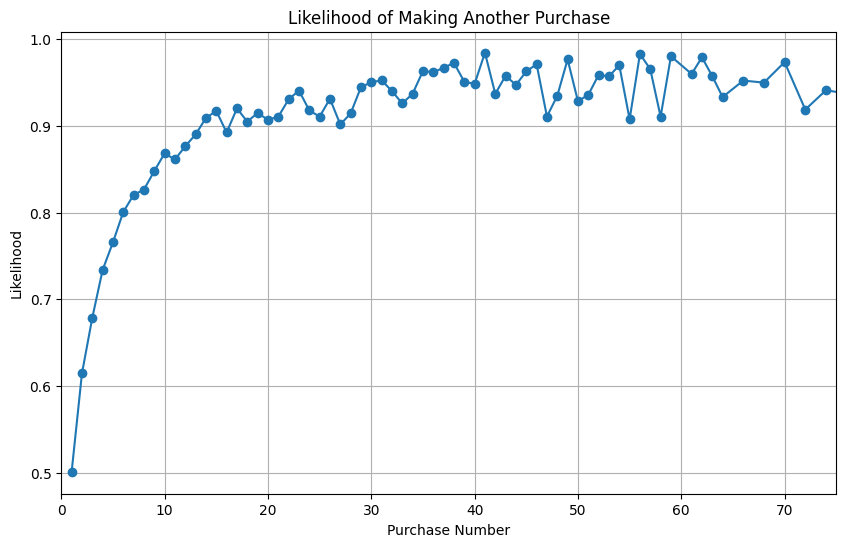

In [33]:
# Convert TRANSACTION_DATE to datetime
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Define the start and end dates for identifying the first purchase
start_date = '2022-07-01'
end_date = '2023-06-30'

# Find the first purchase within the specified window for each user
first_purchases = df[(df['TRANSACTION_DATE'] >= start_date) & (df['TRANSACTION_DATE'] <= end_date)].groupby('USER_ID')['TRANSACTION_DATE'].min().reset_index()
first_purchases.columns = ['USER_ID', 'FirstPurchaseDate']

# Filter users to only include those whose first purchase was within the specified window
filtered_users = df.merge(first_purchases, on='USER_ID', how='inner')

# Calculate the end of the 12-month window from the first purchase date
filtered_users['PurchaseWindowEnd'] = filtered_users['FirstPurchaseDate'] + DateOffset(months=12)

# Filter transactions to only include those within the 12-month window from the first purchase
filtered_users = filtered_users[(filtered_users['TRANSACTION_DATE'] >= filtered_users['FirstPurchaseDate']) & (filtered_users['TRANSACTION_DATE'] < filtered_users['PurchaseWindowEnd'])]

# Count the number of purchases for each user within their 12-month window
purchase_counts = filtered_users.groupby('USER_ID').size().reset_index(name='PurchaseCount')

# Create the required DataFrame with user counts per purchase count
purchase_distribution = purchase_counts['PurchaseCount'].value_counts().reset_index()
purchase_distribution.columns = ['PurchaseNumber', 'UserCount']
purchase_distribution = purchase_distribution.sort_values('PurchaseNumber')

# Calculate the cumulative sum of user counts
purchase_distribution['CumulativeUserCount'] = purchase_distribution['UserCount'][::-1].cumsum()[::-1]

# Calculate the likelihood to make another purchase
purchase_distribution['Likelihood'] = purchase_distribution['CumulativeUserCount'].shift(-1) / purchase_distribution['CumulativeUserCount']

# Set the last likelihood value to NaN as there's no next value
purchase_distribution['Likelihood'].iloc[-1] = None

# Display the final DataFrame
purchase_distribution.reset_index(drop=True, inplace=True)
print(purchase_distribution)

# Plot the likelihood data
plt.figure(figsize=(10, 6))
plt.plot(purchase_distribution['PurchaseNumber'], purchase_distribution['Likelihood'], marker='o')
plt.xlabel('Purchase Number')
plt.ylabel('Likelihood')
plt.title('Likelihood of Making Another Purchase')
plt.grid(True)
plt.xlim(0, 75)
plt.show()

In [34]:
filtered_users.head()

,USER_ID,TRANSACTION_DATE,BRAND,CORONA_TOTAL,MODELO_TOTAL,ITEM_QUANTITY,ITEM_UNIT_PRICE,FirstPurchaseDate,PurchaseWindowEnd
0,384,2022-09-10,Corona,25.99,0.0,1,25.99,2022-09-10,2023-09-10
1,954,2023-06-13,Corona,14.99,0.0,1,14.99,2023-06-13,2024-06-13
2,954,2023-07-28,Corona,15.73,0.0,1,15.73,2023-06-13,2024-06-13
3,954,2023-11-02,Corona,6.00,0.0,1,6.00,2023-06-13,2024-06-13
4,1862,2023-02-25,Corona,27.94,0.0,2,13.97,2023-02-25,2024-02-25


In [35]:
# Set display options to show more rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the DataFrame
print(purchase_distribution)

    PurchaseNumber  UserCount  CumulativeUserCount  Likelihood
0                1      14120                28278    0.500672
1                2       5458                14158    0.614494
2                3       2796                 8700    0.678621
3                4       1571                 5904    0.733909
4                5       1015                 4333    0.765751
5                6        661                 3318    0.800784
6                7        477                 2657    0.820474
7                8        378                 2180    0.826606
8                9        274                 1802    0.847947
9               10        201                 1528    0.868455
10              11        184                 1327    0.861341
11              12        141                 1143    0.876640
12              13        110                 1002    0.890220
13              14         81                  892    0.909193
14              15         67                  811    0

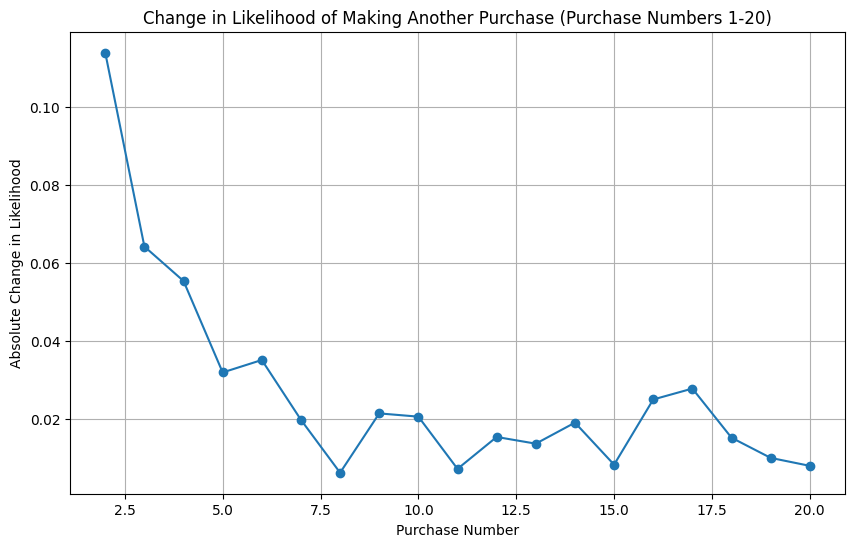

The stabilization point is at Purchase Number: 21.0 with a Likelihood Change of 0.0036


In [36]:
# Calculate the change in likelihood between consecutive purchases
purchase_distribution['Likelihood_Change'] = purchase_distribution['Likelihood'].diff().abs()

# Filter the data to only include Purchase Numbers from 1 to 20
filtered_purchase_distribution = purchase_distribution[purchase_distribution['PurchaseNumber'] <= 20]

# Plot the likelihood changes for Purchase Numbers 1-20
plt.figure(figsize=(10, 6))
plt.plot(filtered_purchase_distribution['PurchaseNumber'], filtered_purchase_distribution['Likelihood_Change'], marker='o')
plt.xlabel('Purchase Number')
plt.ylabel('Absolute Change in Likelihood')
plt.title('Change in Likelihood of Making Another Purchase (Purchase Numbers 1-20)')
plt.grid(True)
plt.show()

# Identify the stabilization point
# Define a small change threshold to determine stabilization
change_threshold = 0.005

# Find the first occurrence where the change is less than or equal to the threshold
stabilization_point = purchase_distribution[purchase_distribution['Likelihood_Change'] <= change_threshold].iloc[0]

print(f"The stabilization point is at Purchase Number: {stabilization_point['PurchaseNumber']} with a Likelihood Change of {stabilization_point['Likelihood_Change']:.4f}")